## importação das bibliotecas

In [3]:
import tensorflow as tf
from tensorflow.keras import models,layers,regularizers
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import pickle
import mlflow
import mlflow.tensorflow
import numpy as np
import keras
import matplotlib.pyplot as plt
%matplotlib inline


### Dataset

In [4]:
# mostrar a quantidade de imagens e classes de treinamento 
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    
    "../data/train",
    
    image_size=(180, 180),  # Definir o tamanho das imagens
    
    batch_size=16 # quantidade de imagens por lote 

)

Found 3286 files belonging to 6 classes.


In [5]:
# mostrar o nome das classes
nomes_classes = dataset.class_names
nomes_classes

['Apple', 'Banana', 'Grape', 'Mango', 'Orange', 'Strawberry']

In [6]:
# Contar a quantidade de imagens por classe

class_counts = {class_name: 0 for class_name in dataset.class_names}

for images, labels in dataset:
    
    for label in labels:
    
        class_name = dataset.class_names[label]
    
        class_counts[class_name] += 1

# Exibir a quantidade de imagens por classe

for class_name, count in class_counts.items():

    print(f'A classe {class_name} tem {count} imagens')

# Exibir a quantidade total de classes

num_classes = len(dataset.class_names)

print(f'Total de classes: {num_classes}')

# Exibir a quantidade total de imagens

total_images = sum(class_counts.values())

print(f'Total de imagens: {total_images}')

# Exibir a porcentagem de imagens por classe

for class_name, count in class_counts.items():

    percentage = (count / total_images) * 100
    
    print(f'A classe {class_name} tem {percentage:.2f}% das imagens')

A classe Apple tem 478 imagens
A classe Banana tem 601 imagens
A classe Grape tem 488 imagens
A classe Mango tem 633 imagens
A classe Orange tem 460 imagens
A classe Strawberry tem 626 imagens
Total de classes: 6
Total de imagens: 3286
A classe Apple tem 14.55% das imagens
A classe Banana tem 18.29% das imagens
A classe Grape tem 14.85% das imagens
A classe Mango tem 19.26% das imagens
A classe Orange tem 14.00% das imagens
A classe Strawberry tem 19.05% das imagens


### Visualização dos dados 

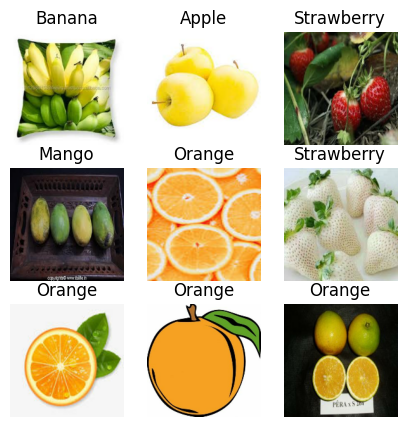

In [8]:
plt.figure(figsize=(5, 5))

for images, labels in dataset.take(1):  # Pegar um lote de imagens
    
    for i in range(9):  # Mostrar as primeiras 9 imagens
        
        ax = plt.subplot(3, 3, i + 1) # exibição das imagens 3X3
        
        plt.imshow(images[i].numpy().astype("uint8"))
        
        plt.title(nomes_classes[labels[i]]) # para mostrar o nome da classe
        
        plt.axis("off")
        
plt.show()

### Dados de treinamento e de validação 

In [11]:
# Parâmetros
image_size = (180, 180)

batch_size = 16

# Caminhos para os dados de treinamento, validação e teste
treinamento_data = "../data/train"

validacao_data = "../data/valid"

test_data = "../data/test"

# Data Augmentation
datagen = ImageDataGenerator(

    rotation_range=20,

    width_shift_range=0.2,

    height_shift_range=0.2,

    shear_range=0.2,

    zoom_range=0.2,

    horizontal_flip=True,

    fill_mode='nearest'

)

train_data_augmented = datagen.flow_from_directory(

    treinamento_data,

    target_size=image_size,

    batch_size=batch_size,

    class_mode='sparse'

)

# Carregar dados de validação e teste
val_data = tf.keras.preprocessing.image_dataset_from_directory(

    validacao_data,

    seed=42,

    image_size=image_size,

    batch_size=batch_size

)

test_data = tf.keras.preprocessing.image_dataset_from_directory(

    test_data,

    seed=42,

    image_size=image_size,

    batch_size=batch_size

)

Found 3286 images belonging to 6 classes.
Found 691 files belonging to 6 classes.
Found 157 files belonging to 6 classes.


In [12]:

# Contar número de imagens e classes
class_names = train_data_augmented.class_indices
num_classes = len(class_names)
num_train_images = train_data_augmented.samples
num_val_images = len(val_data) * batch_size
num_test_images = len(test_data) * batch_size

print(f"Número de imagens de treinamento: {num_train_images}")
print(f"Número de imagens de validação: {num_val_images}")
print(f"Número de imagens de teste: {num_test_images}")
print(f"Número de classes: {num_classes}")

Número de imagens de treinamento: 3286
Número de imagens de validação: 704
Número de imagens de teste: 160
Número de classes: 6


### Modelo RESNET 

In [1]:
# Definir a função get_model

""" 
def get_model(num_classes):
    
   base_model = keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(180, 180, 3))
    
    for layer in base_model.layers:
    
        layer.trainable = False
    
    x = keras.layers.GlobalAveragePooling2D()(base_model.output)
    
    x = keras.layers.Dense(256, activation='relu')(x)
    
    outputs = keras.layers.Dense(num_classes)(x)
    
    model = keras.Model(inputs=base_model.input, outputs=outputs)
    
    return model

"""



" \ndef get_model(num_classes):\n    \n   base_model = keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(180, 180, 3))\n    \n    for layer in base_model.layers:\n    \n        layer.trainable = False\n    \n    x = keras.layers.GlobalAveragePooling2D()(base_model.output)\n    \n    x = keras.layers.Dense(256, activation='relu')(x)\n    \n    outputs = keras.layers.Dense(num_classes)(x)\n    \n    model = keras.Model(inputs=base_model.input, outputs=outputs)\n    \n    return model\n\n"

In [ ]:
# Criar e compilar o modelo

""" 
model = get_model(num_classes)

model.compile(

    optimizer='adam', 
              
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 

    metrics=['accuracy']
)

"""

### ML FLOW

In [33]:
# Parâmetros
image_size = (180, 180)
batch_size = 16

# Caminhos para os dados de treinamento, validação e teste
treinamento_data = "../data/train"
validacao_data = "../data/valid"
test_data = "../data/test"

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=30,    # Aumentar a rotação
    width_shift_range=0.3, # Aumentar o deslocamento
    height_shift_range=0.3,
    shear_range=0.3,      # Aumentar o cisalhamento
    zoom_range=0.3,       # Aumentar o zoom
    horizontal_flip=True,
    fill_mode='nearest'
)

train_data_augmented = datagen.flow_from_directory(
    treinamento_data,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse'
)

# Carregar dados de validação e teste
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    validacao_data,
    seed=42,
    image_size=image_size,
    batch_size=batch_size
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_data,
    seed=42,
    image_size=image_size,
    batch_size=batch_size
)

# Função para obter o modelo
def get_model(num_classes):
    base_model = keras.applications.ResNet50(
        weights='imagenet', 
        include_top=False, 
        input_shape=(180, 180, 3)
    )
    
    for layer in base_model.layers:
        layer.trainable = False

    # Descongelar algumas das camadas superiores
    for layer in base_model.layers[-20:]:
        layer.trainable = True

    x = keras.layers.GlobalAveragePooling2D()(base_model.output)
    x = keras.layers.Dense(256, activation='relu')(x)
    x = keras.layers.Dropout(0.5)(x)  # Adicionar Dropout
    outputs = keras.layers.Dense(num_classes)(x)
   
    model = keras.Model(inputs=base_model.input, outputs=outputs)
    
    return model

# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Configurar o MLflow
mlflow.set_tracking_uri("http://localhost:5000")  # ou o URI do seu servidor MLflow
mlflow.set_experiment("meu_experimento_de_ml")

# Iniciar uma nova execução de MLflow
with mlflow.start_run():

    model = get_model(num_classes)
    learning_rate = 0.0001  # Reduzir a taxa de aprendizado
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
        metrics=['accuracy']
    )
    
    # Treinar o modelo com data augmentation e early stopping
    history = model.fit(
        train_data_augmented, 
        epochs=20, 
        validation_data=val_data, 
        callbacks=[early_stopping]
    )
    
    # Registrar parâmetros
    mlflow.log_param("optimizer", "adam")
    mlflow.log_param("loss", "SparseCategoricalCrossentropy")
    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("epochs", 20)
    
    # Registrar métricas
    for epoch, accuracy in enumerate(history.history['accuracy']):
        mlflow.log_metric("train_accuracy", accuracy, step=epoch)

    for epoch, val_accuracy in enumerate(history.history['val_accuracy']):
        mlflow.log_metric("val_accuracy", val_accuracy, step=epoch)
    
    # Registrar o modelo
    mlflow.tensorflow.log_model(model, "model")

# Visualizar resultados
print("Modelo treinado e registrado com MLflow.")


Found 3286 images belonging to 6 classes.
Found 691 files belonging to 6 classes.
Found 157 files belonging to 6 classes.
Epoch 1/20


c:\Users\brena\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


206/206 ━━━━━━━━━━━━━━━━━━━━ 302s 1s/step - accuracy: 0.4887 - loss: 1.4679 - val_accuracy: 0.7106 - val_loss: 0.8667
Epoch 2/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 230s 1s/step - accuracy: 0.7965 - loss: 0.5991 - val_accuracy: 0.7800 - val_loss: 0.6277
Epoch 3/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 228s 1s/step - accuracy: 0.8465 - loss: 0.4570 - val_accuracy: 0.7699 - val_loss: 0.6724
Epoch 4/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 242s 1s/step - accuracy: 0.8607 - loss: 0.3899 - val_accuracy: 0.7540 - val_loss: 0.7399
Epoch 5/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 246s 1s/step - accuracy: 0.8928 - loss: 0.3044 - val_accuracy: 0.8263 - val_loss: 0.5656
Epoch 6/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 217s 1s/step - accuracy: 0.9122 - loss: 0.2685 - val_accuracy: 0.8017 - val_loss: 0.7771
Epoch 7/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 234s 1s/step - accuracy: 0.9307 - loss: 0.2272 - val_accuracy: 0.8119 - val_loss: 0.7194
Epoch 8/20
206/206 ━━━━━━━━━━━━━━━━━━━━ 251s 1s/step - accuracy: 0.9271 - loss: 0.2320 - val_accuracy: 0.845

2024/07/31 19:18:21 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


Modelo treinado e registrado com MLflow.


### Salvar o modelo

In [34]:
with open('../models/history_resnet50.pkl', 'wb') as file:
    pickle.dump(history.history, file)

In [35]:
model.save('../models/modeloresnet50.h5')

In [13]:
from tensorflow.keras.models import load_model

modelo1 = load_model('../models/modelo1.h5')

### Histórico do modelo

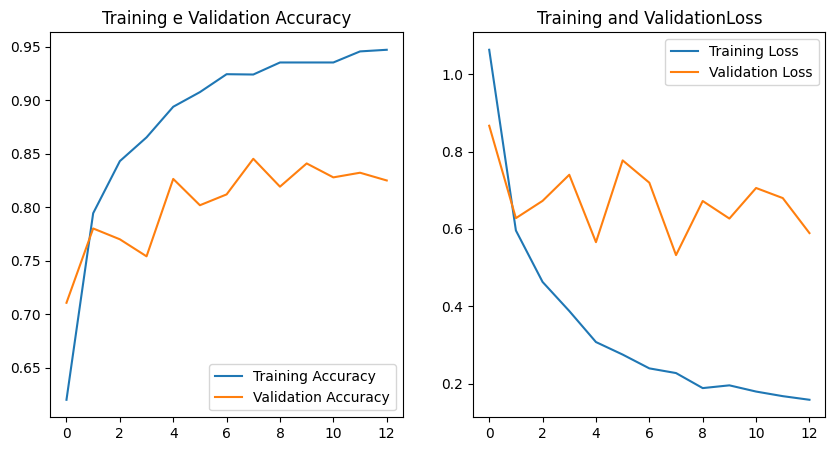

In [37]:
# mostrar o historico de treinamento


accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(13)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training e Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and ValidationLoss')

plt.show()

### Validação do modelo 

In [ ]:
# avaliar o modelo

test_loss, test_acc = model.evaluate(dataset, verbose=2)

print('\nTest accuracy:', test_acc)

print('\nTest loss:', test_loss)

In [47]:
# Carregando o conjunto de dados de validação
validacao_data = tf.keras.preprocessing.image_dataset_from_directory(
    "../data/valid",
    label_mode='int',
    batch_size=32,
    image_size=(180, 180),
    shuffle=False
)

Found 691 files belonging to 6 classes.


In [39]:
validacao_data = "../data/valid"

val_datagen = ImageDataGenerator(rescale=1./255)
val_data = val_datagen.flow_from_directory(
    validacao_data,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse',
        shuffle=False

)

Found 691 images belonging to 6 classes.


Ajustar hiperparâmetros e arquitetura do modelo.
- aumentar a quantidade de parÂmetros para diminuir o overfitting

Aumentar o conjunto de dados para melhorar a precisão.

Utilizar técnicas de aumento de dados para melhorar a robustez do modelo.

## Matriz de confusão 

22/22 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step


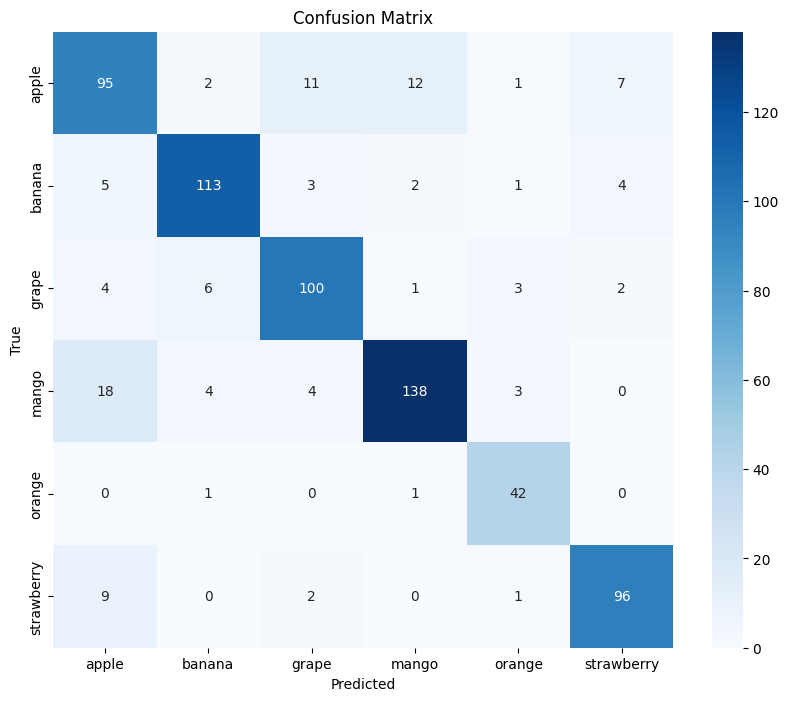

Classification Report:
              precision    recall  f1-score   support

       apple       0.73      0.74      0.73       128
      banana       0.90      0.88      0.89       128
       grape       0.83      0.86      0.85       116
       mango       0.90      0.83      0.86       167
      orange       0.82      0.95      0.88        44
  strawberry       0.88      0.89      0.88       108

    accuracy                           0.85       691
   macro avg       0.84      0.86      0.85       691
weighted avg       0.85      0.85      0.85       691



In [48]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Definindo manualmente os nomes das classes (substitua com suas classes reais)
class_names = ['apple', 'banana', 'grape', 'mango', 'orange', 'strawberry']

# Fazendo previsões no conjunto de teste
y_pred = model.predict(validacao_data)
y_pred_classes = np.argmax(y_pred, axis=1)

# Obtendo os rótulos reais do conjunto de teste
y_true = np.concatenate([y for _, y in validacao_data], axis=0)

# Calculando a matriz de confusão
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plotando a matriz de confusão
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Relatório de classificação
report = classification_report(y_true, y_pred_classes, target_names=class_names)
print("Classification Report:")
print(report)